In [23]:
# Imports
import os
import numpy as np
import pandas as pd
import torch.nn.functional as F
import torch
device = torch.device('mps')
print(device)


mps


In [24]:
# load the dataset
data = pd.read_csv('dataset/Reviews.csv')


In [25]:
# Initial data exploration
print(data.shape)
data.head()


(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [26]:
# Remove all columns except score, smmmary and text

data = data[['Score', 'Summary', 'Text']]
data.head()

,Score,Summary,Text
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,2,Cough Medicine,If you are looking for the secret ingredient i...
4,5,Great taffy,Great taffy at a great price. There was a wid...


In [27]:
# Modify the text by formatting it summary: text, and remove summary column
data['Text'] = data['Summary'] + ': ' + data['Text']
data = data.drop(columns=['Summary'])
data.head()

,Score,Text
0,5,Good Quality Dog Food: I have bought several o...
1,1,Not as Advertised: Product arrived labeled as ...
2,4,"""Delight"" says it all: This is a confection th..."
3,2,Cough Medicine: If you are looking for the sec...
4,5,Great taffy: Great taffy at a great price. Th...


<Axes: xlabel='Score'>

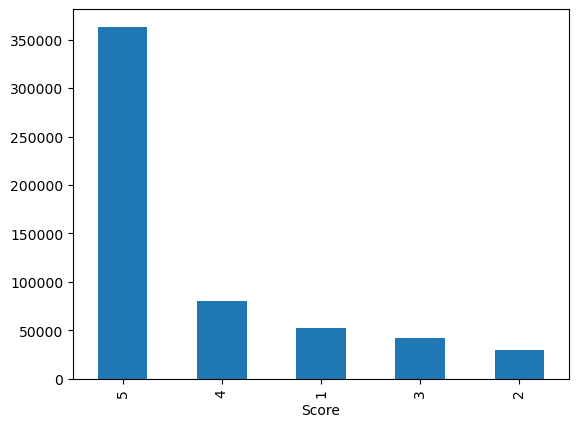

In [28]:
# Bar graoh of the score distribution

data['Score'].value_counts().plot(kind='bar')

# 5 is drastically overrepresented

<Axes: xlabel='Score'>

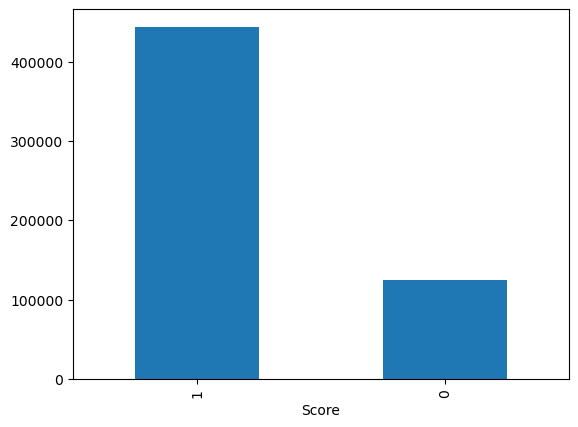

In [29]:
# We map 5 and 4 to 1, 1,2,3 to 0
data['Score'] = data['Score'].apply(lambda x: 1 if x > 3 else 0)
data['Score'].value_counts().plot(kind='bar')


In [30]:
# print max length of text
# First convert all text to string
data['Text'] = data['Text'].astype(str)
print(data['Text'].apply(lambda x: len(x.split())).max())

3451


In [31]:
# look for missing values
print(data.isnull().sum()) # none found


Score    0
Text     0
dtype: int64


In [32]:
from transformers import BertModel
import torch
model = BertModel.from_pretrained("bert-base-uncased", torch_dtype=torch.float16, attn_implementation="sdpa").to(device)

In [33]:
# We import the tokenizer, tokenize a single example and run it through the model to see the output dimensions
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
example = data.Text.iloc[0]
print('Example tweet: ', example)
encoded_input = tokenizer(example, return_tensors='pt').to(device)
with torch.no_grad():
    output = model(**encoded_input)
print('Output dimensions: ', output.last_hidden_state.dtype)
print('CLS token output: ', output.last_hidden_state[0,0,:].shape)


Example tweet:  Good Quality Dog Food: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
Output dimensions:  torch.float16
CLS token output:  torch.Size([768])


In [34]:
import torch
import os
import time
import datetime

def encoder(text):
    encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        output = model(**encoded_input)
    return output.last_hidden_state[:,0,:].squeeze(0)

def create_sharded_dataset(data, n_shards, output_dir, encoder, val=False, start_shard=0):
    os.makedirs(output_dir, exist_ok=True)
    shard_size = len(data) // n_shards
    shard_size += 1 if len(data) % n_shards != 0 else 0
    
    total_time = 0
    for shard_idx in range(start_shard, n_shards):
        start_time = time.time()
        time.sleep(30)

        start_idx = shard_idx * shard_size
        end_idx = min(start_idx + shard_size, len(data))
        shard_data = data.iloc[start_idx:end_idx]

        X = []
        y = []
        for index, row in shard_data.iterrows():
            text = row.Text
            score = row.Score
            numeric_label = torch.tensor(score, dtype=torch.long).to(device)
            X.append(encoder(text).float())
            y.append(numeric_label)
        
        X = torch.stack(X)
        y = torch.stack(y)
        if val:
            torch.save((X, y), os.path.join(output_dir, f'val_shard_{shard_idx}.pt'))
        else:
            torch.save((X, y), os.path.join(output_dir, f'shard_{shard_idx}.pt'))
        
        shard_time = time.time() - start_time
        total_time += shard_time
        completed_shards = shard_idx - start_shard + 1
        estimated_total_time = total_time / completed_shards * (n_shards - start_shard)
        remaining_time = estimated_total_time - total_time
        
        # Convert shard_time and remaining_time to hh:mm:ss format
        shard_time_formatted = str(datetime.timedelta(seconds=int(shard_time)))
        remaining_time_formatted = str(datetime.timedelta(seconds=int(remaining_time)))

        # Combined print statement
        print(f"Shard {shard_idx} saved with {end_idx - start_idx} samples | Time taken for shard {shard_idx}: {shard_time_formatted} | Estimated time remaining: {remaining_time_formatted}")

# We take the last 1000 samples as validation data, and the rest as training data
# create_sharded_dataset(data[:-1000], 500, 'train_shards', encoder, start_shard=293)
# create_sharded_dataset(data.head(50), 50, 'train_shards', encoder)

# create_sharded_dataset(data[-1000:], 1, 'val_shards', encoder, val=True)


In [44]:
import torch
import os

class DataLoader:
    def __init__(self, shard_dir, batch_size, device):
        self.shard_dir = shard_dir
        self.batch_size = batch_size
        self.device = device
        self.shard_files = sorted([os.path.join(shard_dir, f) for f in os.listdir(shard_dir) if f.endswith('.pt')])
        self.current_shard_idx = 0
        self.load_shard(self.current_shard_idx)
        
        # Calculate the total number of samples across all shards
        self.total_samples = 0
        for shard_file in self.shard_files:
            X, _ = torch.load(shard_file)
            self.total_samples += len(X)
        
        # Calculate the total number of batches
        self.total_batches = self.total_samples // self.batch_size
        if self.total_samples % self.batch_size != 0:
            self.total_batches += 1

    def load_shard(self, shard_idx):
        self.X, self.y = torch.load(self.shard_files[shard_idx])
        self.index = 0
        self.length = len(self.X)

    def next_batch(self):
        if self.index + self.batch_size > self.length:
            self.current_shard_idx += 1
            if self.current_shard_idx >= len(self.shard_files):
                self.current_shard_idx = 0  # Reset to the first shard if we reach the end
            self.load_shard(self.current_shard_idx)
            self.index = 0
        
        end_index = min(self.index + self.batch_size, self.length)
        X_batch = self.X[self.index:end_index].to(self.device)
        y_batch = self.y[self.index:end_index].to(self.device)
        self.index = end_index
        return X_batch, y_batch
    
    def reset(self):
        self.current_shard_idx = 0
        self.load_shard(self.current_shard_idx)
        self.index = 0


batch_size = 128
train_loader = DataLoader('train_shards', batch_size, device)
val_loader = DataLoader('val_shards', batch_size, device)
print('Total batches in training set: ', train_loader.total_batches)
print('Total batches in validation set: ', val_loader.total_batches)


Total batches in training set:  4434
Total batches in validation set:  8


In [36]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, dropout_prob=0.5):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, x, targets=None):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        if targets is not None:
            loss = F.cross_entropy(x, targets)
            return x, loss 
        return x

In [37]:
# We calculate accuracy, precision, recall and F1 score on the validation set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
model.eval()
# Evaluate the model on the validation set
def evaluate_model(model, data_loader):
    all_preds = []
    all_labels = []

    data_loader.reset()
    for _ in range(data_loader.total_batches):
        X_batch, y_batch = data_loader.next_batch()
        with torch.no_grad():
            output = model(X_batch)
        preds = torch.argmax(output, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    return accuracy, precision, recall, f1, all_labels, all_preds


In [38]:
model = FFNN(768, 1024, 512, 2, dropout_prob=0.2).to(device)
# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')
lossi = []
val_lossi = []
accuracyi = []
precisioni = []
recalli = []
f1i = []
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)


Number of parameters: 1,313,282


In [99]:
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.00005)


In [117]:
epochs = 300
validate_loss_every = 1000
validate_metrics_every = 1000

model.train()
for epoch in range(epochs):
    for i in range(train_loader.total_batches):
        X_batch, y_batch = train_loader.next_batch()
        optimizer.zero_grad()
        output, loss = model(X_batch, y_batch)
        lossi.append(loss.item())
        loss.backward()
        optimizer.step()

        if i % validate_loss_every == 0:
            model.eval()
            val_loss = 0
            val_loader.reset()
            for _ in range(val_loader.total_batches):
                X_batch, y_batch = val_loader.next_batch()
                output, loss = model(X_batch, y_batch)
                val_loss += loss.item()
            val_loss /= val_loader.total_batches
            val_lossi.append(val_loss)
            val_loader.reset()
            model.train()

        if i % validate_metrics_every == 0:
            model.eval()
            accuracy, precision, recall, f1, _, _ = evaluate_model(model, val_loader)
            accuracyi.append(accuracy)
            precisioni.append(precision)
            recalli.append(recall)
            f1i.append(f1)
            model.train()

    print('Epoch:', epoch, '| Loss average over last epoch: ', np.mean(lossi[-train_loader.total_batches:]), '| Validation loss: ', val_loss)

Epoch: 0 | Loss average over last epoch:  0.06574621335242026 | Validation loss:  0.11319779022596776
Epoch: 1 | Loss average over last epoch:  0.06509188416878783 | Validation loss:  0.11681976297404617
Epoch: 2 | Loss average over last epoch:  0.06501956063017218 | Validation loss:  0.11625339917372912
Epoch: 3 | Loss average over last epoch:  0.06539072239984467 | Validation loss:  0.11545422300696373
Epoch: 4 | Loss average over last epoch:  0.06518785211762891 | Validation loss:  0.11852471972815692
Epoch: 5 | Loss average over last epoch:  0.06546998727488229 | Validation loss:  0.11432655435055494
Epoch: 6 | Loss average over last epoch:  0.06550962797980558 | Validation loss:  0.11500698979943991
Epoch: 7 | Loss average over last epoch:  0.0652236549378697 | Validation loss:  0.11638118082191795
Epoch: 8 | Loss average over last epoch:  0.06434641511097171 | Validation loss:  0.11553931690286845
Epoch: 9 | Loss average over last epoch:  0.06505221790235227 | Validation loss:  0

KeyboardInterrupt: 

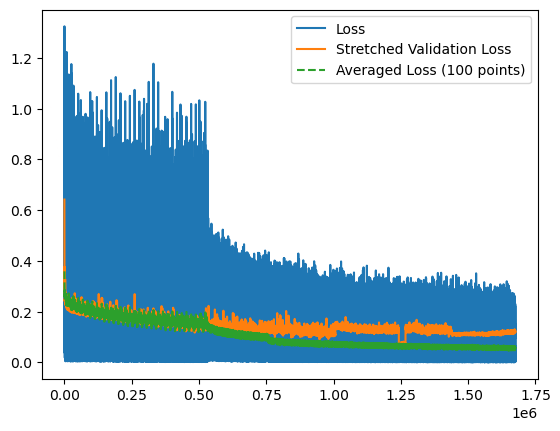

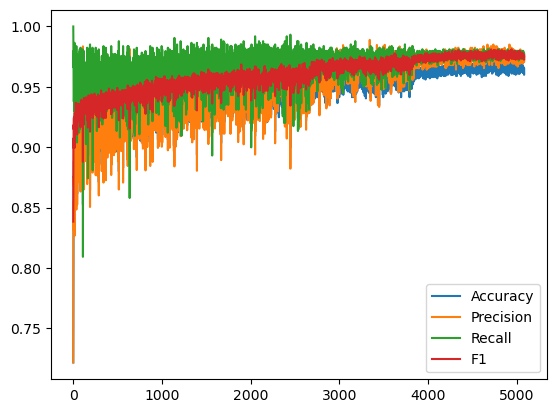

In [118]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming lossi and val_lossi are already defined arrays
# Stretch val_lossi to match the length of lossi
val_lossi_stretched = np.interp(
    np.linspace(0, len(val_lossi) - 1, len(lossi)),
    np.arange(len(val_lossi)),
    val_lossi
)

# Calculate the average loss over 100 data points
window_size = 500
lossi_avg = np.convolve(lossi, np.ones(window_size)/window_size, mode='valid')

# Plot the original loss, stretched validation loss, and averaged loss
plt.plot(lossi, label='Loss')
plt.plot(val_lossi_stretched, label='Stretched Validation Loss')
plt.plot(np.arange(len(lossi_avg)) + window_size//2, lossi_avg, label='Averaged Loss (100 points)', linestyle='--')
plt.legend()
plt.show()



plt.plot(accuracyi, label = 'Accuracy')
plt.plot(precisioni, label = 'Precision')
plt.plot(recalli, label = 'Recall')
plt.plot(f1i, label = 'F1')
plt.legend()
plt.show()

In [119]:

# Calculate and print metrics
val_loader.reset()
accuracy, precision, recall, f1, all_labels, all_preds = evaluate_model(model, val_loader)
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

# We do the same over the entire train dataset
train_loader.reset()
train_accuracy, train_precision, train_recall, train_f1, _, _ = evaluate_model(model, train_loader)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Train Recall: {train_recall:.4f}")
print(f"Train F1 Score: {train_f1:.4f}")


Validation Accuracy: 0.9541
Validation Precision: 0.9703
Validation Recall: 0.9664
Validation F1 Score: 0.9683
Train Accuracy: 0.9760
Train Precision: 0.9820
Train Recall: 0.9874
Train F1 Score: 0.9847


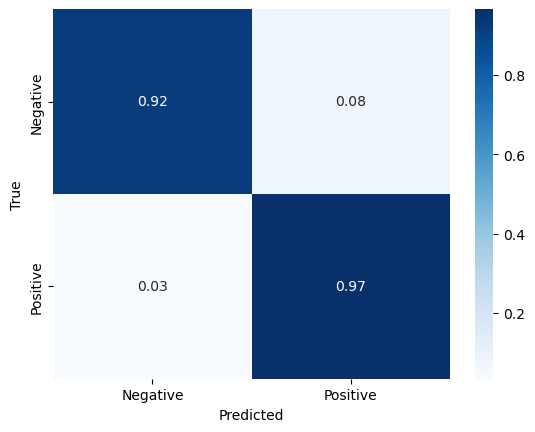

In [120]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, class_names, normalize=False):
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(all_labels, all_preds, class_names=['Negative', 'Positive'], normalize=True)  # Replace with actual class names

In [115]:
import random

max_errors_to_find = 100  # Variable to specify how many errors to find

# Load the data from val_shards/val_shard_0.pt
# Need to recover the text from the original dataset, since X has already gone through BERT (so we need to also memorize the indices, remembering that the val data is taken from the last 1000 reviews)
X, y = torch.load('val_shards/val_shard_0.pt')
X, y = X.to(device), y.to(device)

errors = []
error_indices = []

model.eval()
with torch.no_grad():
    output = model(X)
    preds = torch.argmax(output, dim=1)
    confidences = torch.max(torch.softmax(output, dim=1), dim=1)[0]

for i in range(len(X)):
    if preds[i] != y[i]:
        errors.append((X[i], y[i], preds[i], confidences[i], i))
    if len(errors) >= max_errors_to_find:
        break

# Shuffle and select 5 random errors
random_errors = random.sample(errors, min(5, len(errors)))

# Assuming 'data' is the original DataFrame and contains at least 1000 rows
for error in random_errors:
    x, real_class, pred_class, confidence, idx = error
    decoded_text = tokenizer.decode(x, skip_special_tokens=True)
    # Access the last 1000 rows and use index 'I' from the error list
    data_index = len(data) - 1000 + idx
    print('Text:', data.iloc[data_index].Text)
    print('Real class:', real_class.item())
    print('Predicted class:', pred_class.item())
    print('Confidence score:', confidence.item())
    print('---')

Text: Great Alternative Sweetener: My review covers the Stevia In The Raw product in packet form. I have not tried the bulk product.<br /><br />This is a great alternative sweetener. It leaves no after taste that I can detect. I use it in tea, on cereal and in three different kinds of oatmeal. Everything that I have used it in or on has tasted the same as it did when sugar was used.<br /><br />I cam accross a couple of articles on Stevia while browsing on the Internet. After reading those two articles I did a little more research and decided to try Stevia. I found this product at our local Kroger store where it happened to be on sale. Kroger carries two ro three other Stevia based products however after comparing the list of ingredients for each I decided to buy the Stevia In The Raw. The list of ingredients for the packet form of this product is dextrose and Stevia Extract (Rebiana).<br /><br />OK, I tired it and it tastes great in everyhting I have used it with but I was curious. The

In [122]:
# Save model
torch.save(model.state_dict(), 'model.pth')

